**Review**
	  
Hi, my name is Dmitry and I will be reviewing your project.
  
You can find my comments in colored markdown cells:
  
<div class="alert alert-success">
  If everything is done successfully.
</div>
  
<div class="alert alert-warning">
  If I have some (optional) suggestions, or questions to think about, or general comments.
</div>
  
<div class="alert alert-danger">
  If a section requires some corrections. Work can't be accepted with red comments.
</div>
  
Please don't remove my comments, as it will make further review iterations much harder for me.
  
Feel free to reply to my comments or ask questions using the following template:
  
<div class="alert alert-info">
  For your comments and questions.
</div>
  
First of all, thank you for turning in the project! You did an excellent job! The project is accepted. Good luck on the final sprint! :)

<div class="alert alert-info" role="alert">
Dear Reviewer, 
    
<br>Thank you for reviewing my work. 
    
<br>I had to comment out some lines because the Platform's checking mechanism did not like the "extra" things that I had done.

    
<br>Rena Bracha
</div>

<div class="alert alert-success">
<b>Reviewer's comment</b>
	  
Ok, no problem!
	  
</div>

## Tables of Contents <a class="anchor" id="table_of_contents"></a>

* [Initialization](#chapter1)
* [Load Data](#chapter2)
* [EDA](#chapter3)
    * [Findings](#section_3_1)
* [Modelling](#chapter4)
    * [Prepare the Script to Run on the GPU Platform](#section_7_1)
    * [Output)
* [Conclusions](#chapter5)

## Initialization

## Load Data

The dataset is stored in the `/datasets/faces/` folder, there you can find
- The `final_files` folder with 7.6k photos
- The `labels.csv` file with labels, with two columns: `file_name` and `real_age`

Given the fact that the number of image files is rather high, it is advisable to avoid reading them all at once, which would greatly consume computational resources. We recommend you build a generator with the ImageDataGenerator generator. This method was explained in Chapter 3, Lesson 7 of this course.

The label file can be loaded as an usual CSV file.

In [1]:
import pandas as pd
import numpy as np
#from PIL import Image
import matplotlib.pyplot as plt
#!pip install seaborn --upgrade
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [28]:
from PIL import Image

In [2]:
# verify the required version of seaborn has been installed
#import seaborn as sns
#sns.__version__ # '0.11.2'

In [3]:
path = '/datasets/faces/'
directory = path + 'final_files/'
labels = pd.read_csv(path + "labels.csv")

In [4]:
train_datagen = ImageDataGenerator(rescale=1./255)

In [5]:
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe= labels,
        directory= directory,
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [93]:
image_arrays, age_array = train_gen_flow.next()

## EDA

In [94]:
# labels.info()
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [95]:
#image_arrays.shape

In [99]:
#image = Image.open(train_gen_flow.filepaths[4])
#array = np.array(image)
#plt.imshow(array)

* The 'labels' dataset consists of two columns: 'file_name' (the name of an image file) and 'real_age' (the age of the person in the image), and the actual image files are pulled from '/datasets/faces/final_files/' using ImageDataGenerator. 
* The 'labels' dataset contains a list of 7591 image file names, which is not large. 
* The data generator found 7591 images, each of which is a four-dimensional tensor of thirty-two 224x224 pixel images with three colour channels. 


Let us look at the age distribution in the dataset. 

In [93]:
#labels.describe()

In [94]:
#labels['real_age'].value_counts()

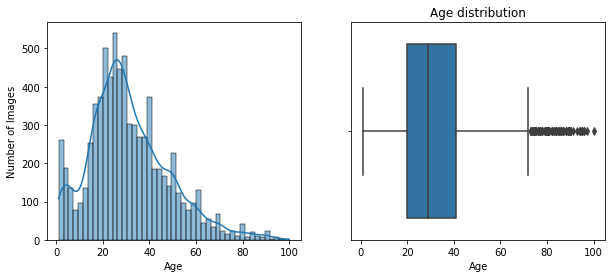

In [95]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
sns.histplot(data=labels, x="real_age", kde=True, ax=ax[0])
sns.boxplot(x="real_age", data=labels, ax=ax[1]) 
plt.title("Age distribution")
ax[0].set(xlabel='Age', ylabel='Number of Images')
ax[1].set_xlabel('Age')
plt.show();

* Age range: 0 - 100 years old. 
* The distribution is slightly skewed to the right. We do not have an equal number of images for each age. We have the largest amount of data in the 20-40 year-old age group.
 

Let us look at 15 randomly chosen photos of people at various ages. 

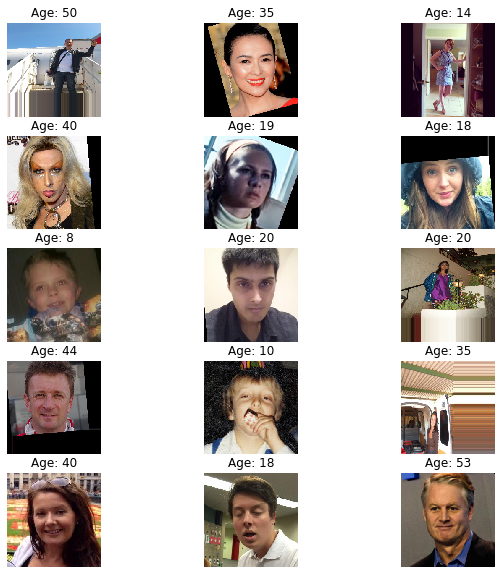

In [102]:
n_images = 15
rows = 5
columns = n_images/rows

fig = plt.figure(figsize=(10, 10))
image_arrays, age_array = train_gen_flow.next()

for i in range(n_images):
    # add a subplot at the (i+1)th position
    fig.add_subplot(rows, columns, i+1)
    # showing image
    image_file = image_arrays[i]
    age_num = age_array[i]
    plt.imshow(image_file) 
    plt.axis('off')
    plt.title(f"Age: {age_num}")

### Findings

* Resolution, lighting, and face angles are different from image to image.
* There is a wide variety of race and gender, in addition to age. 
* Some images show the whole body of the person and his/her face is too small to be recognised. 
* Each image contains a background, and it is a large area that does not offer the information about a person's face. 
* Some photos are "a frame within a frame", and are rotated. Again, a person's face does not fill the entire display space of the image. 
* Some images are warped and stretched. 
* Some images suffer from partial occlusion with part of the face hidden by an object (e.g. a veil, a microphone, food, eyes closed...etc).
* Some images are in colour and others are in monochrome.

<div class="alert alert-success">
<b>Reviewer's comment</b>
	  
Very good, you studied target distribution, looked at examples of images and made some interesting observations!
	  
</div>

## Modelling

Define the necessary functions to train your model on the GPU platform and build a single script containing all of them along with the initialization section.

To make this task easier, you can define them in this notebook and run a ready code in the next section to automatically compose the script.

The definitions below will be checked by project reviewers as well, so that they can understand how you built the model.

In [ ]:
import pandas as pd

#import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

In [ ]:
def load_train(path):
    
    """
    It loads the train part of dataset from path
    """
    
    train_datagen = ImageDataGenerator(validation_split=0.25, 
                                       rescale=1.0/255
                                ) 

    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=pd.read_csv(path + "labels.csv"),
        directory=path +'final_files/', 
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16, # 32
        class_mode='raw',
        subset='training',
        seed=12345
    ) 
    
    return train_gen_flow

In [ ]:
def load_test(path):
    
    """
    It loads the validation/test part of dataset from path
    """
    
    test_datagen = ImageDataGenerator(
        validation_split=0.25, rescale=1.0/255
    )

    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=pd.read_csv(path + "labels.csv"),
        directory=path +'final_files/', 
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16, # 32
        class_mode='raw',
        subset='validation',
        seed=12345
    )
    
    return test_gen_flow

In [ ]:
def create_model(input_shape=(224, 224, 3)):
    
    """
    It defines the model
    """
    
    backbone = ResNet50(
        input_shape=input_shape, #(224, 224, 3), 
        weights='imagenet', 
        include_top=False 
    )

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    #model.add(Dropout(0.5))
    model.add(Dense(1, activation='relu')) 

    model.compile(
        loss='mse', 
        optimizer=Adam(learning_rate=0.0001), # default is 0.001
        metrics=['mae']
    )
    
    #print(model.summary())    
    return model

In [ ]:
def train_model(
    model, 
    train_data, 
    test_data, 
    batch_size=None, 
    epochs=20,
    steps_per_epoch=None, 
    validation_steps=None
):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)    
    
    """
    Trains the model given the parameters
    """
    
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2
    )
    
    return model

<div class="alert alert-success">
<b>Reviewer's comment</b>
	  
The code for data loading, model creation and training is correct!
	  
</div>

### Prepare the Script to Run on the GPU Platform

Given you've defined the necessary functions you can compose a script for the GPU platform, download it via the "File|Open..." menu, and to upload it later for running on the GPU platform.

N.B.: The script should include the initialization section as well. An example of this is shown below.

In [ ]:
# prepare a script to run on the GPU platform

init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

### Output

Place the output from the GPU platform as an Markdown cell here.

Below is the GPU output at a 0.0001 learning rate that produced the best result after a few trials. The code that is shown above is the corresponding code that produced this result. 

2021-12-03 04:57:16.462106: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer.so.6
2021-12-03 04:57:16.463807: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer_plugin.so.6
Using TensorFlow backend.
Found 5694 validated image filenames.
Found 1897 validated image filenames.
2021-12-03 04:57:17.299475: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2021-12-03 04:57:17.970690: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2021-12-03 04:57:17.970773: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2021-12-03 04:57:17.970807: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2021-12-03 04:57:17.972450: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2021-12-03 04:57:17.972829: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2021-12-03 04:57:17.975058: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2021-12-03 04:57:17.976625: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2021-12-03 04:57:17.976733: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2021-12-03 04:57:17.981953: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2021-12-03 04:57:17.982388: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2021-12-03 04:57:17.992939: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2099990000 Hz
2021-12-03 04:57:17.993562: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x52de370 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2021-12-03 04:57:17.993594: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2021-12-03 04:57:18.136968: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5364390 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2021-12-03 04:57:18.137003: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
2021-12-03 04:57:18.139455: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2021-12-03 04:57:18.139523: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2021-12-03 04:57:18.139541: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2021-12-03 04:57:18.139579: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2021-12-03 04:57:18.139591: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2021-12-03 04:57:18.139603: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2021-12-03 04:57:18.139613: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2021-12-03 04:57:18.139621: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2021-12-03 04:57:18.144074: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2021-12-03 04:57:18.144140: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2021-12-03 04:57:18.458706: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1096] Device interconnect StreamExecutor with strength 1 edge matrix:
2021-12-03 04:57:18.458763: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1102]      0 
2021-12-03 04:57:18.458771: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] 0:   N 
2021-12-03 04:57:18.463311: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1241] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 30509 MB memory) -> physical GPU (device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:8b:00.0, compute capability: 7.0)
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 356 steps, validate for 119 steps
Epoch 1/20
2021-12-03 04:57:28.955122: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2021-12-03 04:57:29.245077: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 46s - loss: 250.3596 - mae: 11.3836 - val_loss: 681.2971 - val_mae: 21.1414
Epoch 2/20
356/356 - 38s - loss: 71.0135 - mae: 6.4112 - val_loss: 182.2540 - val_mae: 10.0737
Epoch 3/20
356/356 - 38s - loss: 38.2638 - mae: 4.7689 - val_loss: 74.9958 - val_mae: 6.5332
Epoch 4/20
356/356 - 38s - loss: 23.1779 - mae: 3.7243 - val_loss: 80.9212 - val_mae: 6.8435
Epoch 5/20
356/356 - 38s - loss: 16.0605 - mae: 3.0580 - val_loss: 72.4055 - val_mae: 6.4446
Epoch 6/20
356/356 - 37s - loss: 13.5417 - mae: 2.7815 - val_loss: 87.6135 - val_mae: 7.3923
Epoch 7/20
356/356 - 37s - loss: 11.4183 - mae: 2.5754 - val_loss: 70.7568 - val_mae: 6.4355
Epoch 8/20
Epoch 9/20
356/356 - 37s - loss: 10.0787 - mae: 2.3931 - val_loss: 75.5878 - val_mae: 6.4279
356/356 - 37s - loss: 10.0268 - mae: 2.4047 - val_loss: 68.3380 - val_mae: 6.2453
Epoch 10/20
356/356 - 37s - loss: 10.1127 - mae: 2.4078 - val_loss: 84.8045 - val_mae: 6.8381
Epoch 11/20
356/356 - 37s - loss: 10.3391 - mae: 2.4361 - val_loss: 67.3096 - val_mae: 6.2958
Epoch 12/20
356/356 - 37s - loss: 10.3395 - mae: 2.4501 - val_loss: 70.3187 - val_mae: 6.2835
Epoch 13/20
356/356 - 37s - loss: 9.8749 - mae: 2.3996 - val_loss: 86.7052 - val_mae: 7.3256
Epoch 14/20
356/356 - 37s - loss: 9.5057 - mae: 2.3194 - val_loss: 70.0232 - val_mae: 6.4939
Epoch 15/20
356/356 - 37s - loss: 8.3322 - mae: 2.1723 - val_loss: 64.2112 - val_mae: 5.9775
Epoch 16/20
356/356 - 37s - loss: 7.5355 - mae: 2.0689 - val_loss: 65.3910 - val_mae: 6.1365
Epoch 17/20
356/356 - 37s - loss: 6.9998 - mae: 1.9991 - val_loss: 70.7078 - val_mae: 6.4596
Epoch 18/20
356/356 - 37s - loss: 6.8282 - mae: 1.9987 - val_loss: 63.7285 - val_mae: 6.0568
Epoch 19/20
356/356 - 37s - loss: 6.9269 - mae: 1.9903 - val_loss: 63.0750 - val_mae: 5.9572
Epoch 20/20
356/356 - 37s - loss: 6.8346 - mae: 1.9729 - val_loss: 64.0239 - val_mae: 6.1386
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 9s - loss: 64.0239 - mae: 6.1386
Test MAE: 6.1386

<div class="alert alert-success">
<b>Reviewer's comment</b>
	  
The model was trained successfully
	  
</div>

## Conclusions

The table below shows the result of four trial runs:

| 	Dropout	| 	Learning Rate	| 	Test MAE	 | 
|----------		|----------		|----------		 | 
| 	None	| 	0.0001	| 	6.1386	 | 
| 	0.5	| 	0.0001	| 	6.2736	 | 
| 	None	| 	0.0005	| 	6.6262	 | 
| 	0.5	| 	0.0003	| 	6.8561	 | 


With just three layers of neurons, the best model configuration managed to predict a person's age from his/her photograph with an error margin of 6.1 years on average. The data size was rather small, but the pre-trained ResNet50 model did not require data augmentation or regularization, and did not overfit using the power of transfer learning. 


<br>When we looked at the images before training the model, we had enumerated all sorts of apparent obstacles. A learning rate of 0.0001 is very slow and costly. If we were to address them, we may get an even better accuracy and learning performance.
* Resolution, lighting, and face angles are different from image to image. -> Adjust all of them to be equal. 
* There is a wide variety of race and gender, in addition to age. -> Separate the data into age, race and gender groups and train a model for each to build several models, each becoming an expert at identifying a certain group. 
* Some images show the whole body of the person and his/her face is too small to be recognised. -> Ideally, these images should be excluded from the training dataset since there is nothing that can learned from them. 
* Each image contains a background, and it is a large area that does not offer the information about a person's face. -> Zoom in on the area where there is face to exclude non-informative pixles. 
* Some photos are "a frame within a frame", and are rotated. Again, a person's face does not fill the entire display space of the image. -> Crop and rotate to get a new image only with the person's face and with no rotation. 
* Some images are warped and stretched. -> Reverse the warping and stretching effects.
* Some images suffer from partial occlusion with part of the face hidden by an object (e.g. a veil, a microphone, food, eyes closed...etc). -> Apply face restoration strategies to remove the occluding objects. 
* The data size with 7591 rows is not large. -> Increase the data size by data augmentation.
* Some images are in colour and others are in monochrome. -> By turning the images to grayscale and applying Canny Edge Detection, we could sharpen the edges and see the main features of the images (gender, age and race) more clearly. While we lose the information on colour complexion that assists discerning between races, the racial features will be more pronounced (e.g. height and shape of the nose, shape of the eyes,...etc). 
* The distribution is slightly skewed to the right. We do not have an equal number of images for each age. We have the largest amount of data in the 20-40 year-old age group. -> We ran the risk of the model learning to perform the best on the 20-40 year-old age group. We can balance out the differences by data augmentation to increase the images in the other age groups. 


<br>An error margin of 6.1 years, however, does not seem viable in our context. This project is about estimating the age of customers who walk into a Good Seed supermarket so as not to sell alcohol to underage customers. The minimum legal age for purchasing alcohol is between 18 and 21 years of age. If a 11.9 year-old (= 18-6.1) is cleared by the ML model as being 18 years old, there is going to be a problem. The project instruction mentions the lowest MAE value recorded of 5.4 years as being a major success, but even that does not seem enough in our particular circumstance (i.e. a 12.6 year-old has a chance of passing as an 18 year-old). 

<br>With this level of accuracy, we will need a more lenient scenario than an attempt to conform to law. Also, we can lower our expectations by determining an age range rather than a specific age. A couple of examples might be to guess the age of a person who (a) is not sure when his/her birthday is (in some regions of the world, proper steps are/were not taken to register a new born's birthdate); (b) passed away with no one to identify him/her. The latter could also be extended to assisting forensic anthropologists, part of whose job it is to determine the age range of a deceased, though from skeletons and not faces, but picking up features would be a similar task for machine learning models. 

<div class="alert alert-success">
<b>Reviewer's comment</b>
	  
Excellent analysis of the model, how it could be improved and its suitability for the proposed business case! It's great that you experimented with dropout and learning rate! 
	  
</div>

# Checklist

- [x]  Notebook was opened
- [x]  The code is error free
- [x]  The cells with code have been arranged by order of execution
- [x]  The exploratory data analysis has been performed
- [x]  The results of the exploratory data analysis are presented in the final notebook
- [x]  The model's MAE score is not higher than 8
- [x]  The model training code has been copied to the final notebook
- [x]  The model training output has been copied to the final notebook
- [x]  The findings have been provided based on the results of the model training